In [56]:
"""
================================================================================
SKU-Level Inventory Demand Forecasting System
================================================================================
Project: Advanced ML-based demand forecasting for inventory optimization
Author: [Aqsa Siddiqui]

Business Impact:
- Optimize inventory levels to reduce holding costs
- Prevent stockouts and improve service levels
- Enable data-driven reorder point decisions
- Forecast demand for better supply chain planning
================================================================================
"""

'\n================================================================================\nSKU-Level Inventory Demand Forecasting System\n================================================================================\nProject: Advanced ML-based demand forecasting for inventory optimization\nAuthor: [Aqsa Siddiqui]\n\nBusiness Impact:\n- Optimize inventory levels to reduce holding costs\n- Prevent stockouts and improve service levels\n- Enable data-driven reorder point decisions\n- Forecast demand for better supply chain planning\n================================================================================\n'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [3]:
print("="*80)
print("SKU INVENTORY DEMAND FORECASTING SYSTEM")
print("="*80)

SKU INVENTORY DEMAND FORECASTING SYSTEM


In [4]:
print("\n[STEP 1] Loading and exploring dataset...")


[STEP 1] Loading and exploring dataset...


In [5]:
df = pd.read_csv('Inventory Management E-Grocery.csv')

In [6]:
print(f"\nDataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print("\nFirst 5 rows:")
print(df.head())


Dataset Shape: 1000 rows × 37 columns

First 5 rows:
    SKU_ID              SKU_Name       Category ABC_Class Supplier_ID  \
0  SKU0001     Pantry Product 13         Pantry         A        S005   
1  SKU0002     Fresh Product 112  Fresh Produce         C        S004   
2  SKU0003      Meat Product 446           Meat         B        S001   
3  SKU0004    Seafood Product 48        Seafood         A        S007   
4  SKU0005  Personal Product 194  Personal Care         A        S002   

           Supplier_Name Warehouse_ID    Warehouse_Location   Batch_ID  \
0           PT Agro Raya        WHBDG   Bandung - Rancaekek  BATCH2679   
1  PT Nusantara Supplier        WHDPS    Denpasar - Tabanan  BATCH4257   
2        PT Segar Makmur        WHBDG   Bandung - Rancaekek  BATCH6574   
3           PT Bakerindo        WHJKT  Jakarta - Cengkareng  BATCH5333   
4          PT Indo Fresh        WHDPS    Denpasar - Tabanan  BATCH6925   

  Received_Date  ... SKU_Churn_Rate Order_Frequency_per_month 

In [7]:
print("\nColumn Data Types:")
print(df.dtypes)


Column Data Types:
SKU_ID                           object
SKU_Name                         object
Category                         object
ABC_Class                        object
Supplier_ID                      object
Supplier_Name                    object
Warehouse_ID                     object
Warehouse_Location               object
Batch_ID                         object
Received_Date                    object
Last_Purchase_Date               object
Expiry_Date                      object
Stock_Age_Days                    int64
Quantity_On_Hand                  int64
Quantity_Reserved                 int64
Quantity_Committed                int64
Damaged_Qty                       int64
Returns_Qty                       int64
Avg_Daily_Sales                  object
Forecast_Next_30d               float64
Days_of_Inventory                object
Reorder_Point                   float64
Safety_Stock                      int64
Lead_Time_Days                    int64
Unit_Cost_USD       

In [8]:
print("\nBasic Statistics:")
print(df.describe())


Basic Statistics:
       Stock_Age_Days  Quantity_On_Hand  Quantity_Reserved  \
count     1000.000000       1000.000000        1000.000000   
mean        91.541000        231.563000          50.302000   
std         52.475308        201.988781          50.106162   
min          0.000000          0.000000           0.000000   
25%         46.000000         81.000000          15.000000   
50%         95.000000        180.000000          35.000000   
75%        138.000000        320.000000          68.000000   
max        180.000000        977.000000         363.000000   

       Quantity_Committed  Damaged_Qty  Returns_Qty  Forecast_Next_30d  \
count         1000.000000  1000.000000    1000.0000        1000.000000   
mean            38.742000     1.168000       0.8120         332.218940   
std             42.765761     1.295938       0.9206         301.358418   
min              0.000000     0.000000       0.0000           1.000000   
25%             10.000000     0.000000       0.0000 

In [9]:
print("\nMissing Values Summary:")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values!")



Missing Values Summary:
Notes    834
dtype: int64


In [10]:
print("\n" + "="*80)
print("[STEP 2] Data Cleaning & Preprocessing")
print("="*80)


[STEP 2] Data Cleaning & Preprocessing


In [11]:
df_clean = df.copy()

In [12]:
# 2.1: Convert European number format (comma decimals) to standard format
print("\n2.1 Converting European number format (comma → decimal point)...")

def clean_numeric_column(series):
    """
    Clean numeric columns that use comma as decimal separator
    Examples: '5,00' → 5.0, '70,68%' → 70.68, '$1.234,56' → 1234.56
    """
    if series.dtype == 'object':
        # Remove currency symbols, percentage signs, and spaces
        cleaned = series.astype(str).str.replace('$', '', regex=False)
        cleaned = cleaned.str.replace('%', '', regex=False)
        cleaned = cleaned.str.replace(' ', '', regex=False)
        
        # Replace comma with period for decimal
        cleaned = cleaned.str.replace(',', '.', regex=False)
        
        # Convert to numeric
        return pd.to_numeric(cleaned, errors='coerce')
    return series

# Columns that need numeric conversion
numeric_convert_cols = [
    'Avg_Daily_Sales', 'Days_of_Inventory', 'Unit_Cost_USD', 
    'Last_Purchase_Price_USD', 'Total_Inventory_Value_USD',
    'SKU_Churn_Rate', 'Order_Frequency_per_month',
    'Supplier_OnTime_Pct', 'Audit_Variance_Pct', 
    'Demand_Forecast_Accuracy_Pct'
]

for col in numeric_convert_cols:
    if col in df_clean.columns:
        original_type = df_clean[col].dtype
        df_clean[col] = clean_numeric_column(df_clean[col])
        print(f"  ✓ Converted '{col}' from {original_type} to numeric")

# 2.2: Handle date columns
print("\n2.2 Processing date columns...")
date_columns = ['Received_Date', 'Last_Purchase_Date', 'Expiry_Date', 'Audit_Date']

for col in date_columns:
    if col in df_clean.columns:
        try:
            df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
            print(f"  ✓ Converted '{col}' to datetime")
        except:
            print(f"  ✗ Could not convert '{col}' to datetime")

# 2.3: Handle missing values intelligently
print("\n2.3 Handling missing values...")
print("\nMissing values before cleaning:")
missing_before = df_clean.isnull().sum()
print(missing_before[missing_before > 0])


2.1 Converting European number format (comma → decimal point)...
  ✓ Converted 'Avg_Daily_Sales' from object to numeric
  ✓ Converted 'Days_of_Inventory' from object to numeric
  ✓ Converted 'Unit_Cost_USD' from object to numeric
  ✓ Converted 'Last_Purchase_Price_USD' from object to numeric
  ✓ Converted 'Total_Inventory_Value_USD' from object to numeric
  ✓ Converted 'SKU_Churn_Rate' from object to numeric
  ✓ Converted 'Order_Frequency_per_month' from object to numeric
  ✓ Converted 'Supplier_OnTime_Pct' from object to numeric
  ✓ Converted 'Audit_Variance_Pct' from object to numeric
  ✓ Converted 'Demand_Forecast_Accuracy_Pct' from object to numeric

2.2 Processing date columns...
  ✓ Converted 'Received_Date' to datetime
  ✓ Converted 'Last_Purchase_Date' to datetime
  ✓ Converted 'Expiry_Date' to datetime
  ✓ Converted 'Audit_Date' to datetime

2.3 Handling missing values...

Missing values before cleaning:
Total_Inventory_Value_USD    441
SKU_Churn_Rate                 1
Notes 

In [13]:
# Get all numeric columns
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns

# Fill numeric columns with median (robust to outliers)
for col in numeric_cols:
    if df_clean[col].isnull().sum() > 0:
        median_val = df_clean[col].median()
        
        # If entire column is NaN, use 0
        if pd.isna(median_val):
            print(f"  ⚠ Column '{col}' is entirely NaN, filling with 0")
            df_clean[col].fillna(0, inplace=True)
        else:
            df_clean[col].fillna(median_val, inplace=True)
            print(f"  ✓ Filled '{col}' missing values with median: {median_val:.2f}")

# Handle infinite values
df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)

# Final pass to ensure no NaN in numeric columns
for col in numeric_cols:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(0, inplace=True)

print("\nMissing values after cleaning:")
missing_after = df_clean.isnull().sum()
print(missing_after[missing_after > 0] if missing_after.sum() > 0 else "✓ All numeric columns cleaned!")

# 2.4: Verify key columns
print("\n2.4 Verifying key columns for analysis...")
required_cols = ['Avg_Daily_Sales', 'Forecast_Next_30d', 'Quantity_On_Hand', 
                'Quantity_Reserved', 'Quantity_Committed', 'Reorder_Point', 
                'Safety_Stock', 'Lead_Time_Days']

available_cols = [col for col in required_cols if col in df_clean.columns]
print(f"✓ Available key columns: {len(available_cols)}/{len(required_cols)}")
for col in available_cols:
    valid_count = df_clean[col].notna().sum()
    print(f"  • {col}: {valid_count} valid values")

print(f"\n✓ Data cleaning complete! Final shape: {df_clean.shape}")



  ✓ Filled 'Total_Inventory_Value_USD' missing values with median: 392.68
  ✓ Filled 'SKU_Churn_Rate' missing values with median: 3.01

Missing values after cleaning:
Notes    834
dtype: int64

2.4 Verifying key columns for analysis...
✓ Available key columns: 8/8
  • Avg_Daily_Sales: 1000 valid values
  • Forecast_Next_30d: 1000 valid values
  • Quantity_On_Hand: 1000 valid values
  • Quantity_Reserved: 1000 valid values
  • Quantity_Committed: 1000 valid values
  • Reorder_Point: 1000 valid values
  • Safety_Stock: 1000 valid values
  • Lead_Time_Days: 1000 valid values

✓ Data cleaning complete! Final shape: (1000, 37)


In [14]:
print("\n" + "="*80)
print("[STEP 3] Exploratory Data Analysis")
print("="*80)


[STEP 3] Exploratory Data Analysis


In [54]:



# ============================================================================
# SECTION 3: EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================
print("\n" + "="*80)
print("[STEP 3] Exploratory Data Analysis")
print("="*80)

# 3.1: Calculate average sales metrics
print("\n3.1 Average Sales Metrics Across All SKUs:")
print("-" * 60)

if 'Avg_Daily_Sales' in df_clean.columns:
    sales_data = df_clean['Avg_Daily_Sales'].replace([np.inf, -np.inf], np.nan).dropna()
    
    if len(sales_data) > 0:
        avg_daily = sales_data.mean()
        median_daily = sales_data.median()
        std_daily = sales_data.std()
        total_daily = sales_data.sum()
        
        print(f"Mean Daily Sales per SKU:     {avg_daily:.2f} units")
        print(f"Median Daily Sales per SKU:   {median_daily:.2f} units")
        print(f"Std Dev Daily Sales:          {std_daily:.2f} units")
        print(f"Total Daily Sales (All SKUs): {total_daily:.2f} units")
        print(f"Projected Monthly Sales:      {total_daily * 30:.2f} units")
        print(f"Projected Annual Sales:       {total_daily * 365:.2f} units")

# 3.2: Inventory health metrics
print("\n3.2 Inventory Health Metrics:")
print("-" * 60)

if all(col in df_clean.columns for col in ['Quantity_On_Hand', 'Avg_Daily_Sales']):
    # Calculate Days of Inventory
    df_clean['Days_Of_Inventory_Calc'] = df_clean['Quantity_On_Hand'] / df_clean['Avg_Daily_Sales'].replace(0, np.nan)
    df_clean['Days_Of_Inventory_Calc'] = df_clean['Days_Of_Inventory_Calc'].replace([np.inf, -np.inf], np.nan)
    
    days_data = df_clean['Days_Of_Inventory_Calc'].dropna()
    if len(days_data) > 0:
        avg_days = days_data.mean()
        median_days = days_data.median()
        print(f"Average Days of Inventory:    {avg_days:.1f} days")
        print(f"Median Days of Inventory:     {median_days:.1f} days")
        
        # Stock health classification
        df_clean['Stock_Status'] = pd.cut(df_clean['Days_Of_Inventory_Calc'], 
                                           bins=[0, 7, 30, 60, np.inf],
                                           labels=['Critical', 'Low', 'Healthy', 'Overstock'])
        
        print("\nStock Status Distribution:")
        status_dist = df_clean['Stock_Status'].value_counts()
        for status, count in status_dist.items():
            pct = (count / len(df_clean)) * 100
            print(f"  {status}: {count} SKUs ({pct:.1f}%)")

# 3.3: Additional business metrics
print("\n3.3 Additional Business Metrics:")
print("-" * 60)

if 'Lead_Time_Days' in df_clean.columns:
    lead_data = df_clean['Lead_Time_Days'].replace([np.inf, -np.inf], np.nan).dropna()
    if len(lead_data) > 0:
        print(f"Average Lead Time:            {lead_data.mean():.1f} days")
        print(f"Max Lead Time:                {lead_data.max():.1f} days")

if all(col in df_clean.columns for col in ['Reorder_Point', 'Quantity_On_Hand']):
    below_reorder = (df_clean['Quantity_On_Hand'] < df_clean['Reorder_Point']).sum()
    print(f"SKUs Below Reorder Point:     {below_reorder} ({below_reorder/len(df_clean)*100:.1f}%)")

if all(col in df_clean.columns for col in ['Safety_Stock', 'Quantity_On_Hand']):
    below_safety = (df_clean['Quantity_On_Hand'] < df_clean['Safety_Stock']).sum()
    print(f"SKUs Below Safety Stock:      {below_safety} ({below_safety/len(df_clean)*100:.1f}%)")

# 3.4: Category-wise analysis
if 'Category' in df_clean.columns and 'Avg_Daily_Sales' in df_clean.columns:
    print("\n3.4 Sales by Category:")
    print("-" * 60)
    category_sales = df_clean.groupby('Category')['Avg_Daily_Sales'].agg(['mean', 'sum', 'count'])
    category_sales.columns = ['Avg_Daily_Sales', 'Total_Daily_Sales', 'SKU_Count']
    category_sales = category_sales.sort_values('Total_Daily_Sales', ascending=False)
    print(category_sales.round(2))


[STEP 3] Exploratory Data Analysis

3.1 Average Sales Metrics Across All SKUs:
------------------------------------------------------------
Mean Daily Sales per SKU:     26.58 units
Median Daily Sales per SKU:   20.23 units
Std Dev Daily Sales:          21.25 units
Total Daily Sales (All SKUs): 26582.79 units
Projected Monthly Sales:      797483.70 units
Projected Annual Sales:       9702718.35 units

3.2 Inventory Health Metrics:
------------------------------------------------------------
Average Days of Inventory:    9.6 days
Median Days of Inventory:     9.6 days

Stock Status Distribution:
  Low: 759 SKUs (75.9%)
  Critical: 239 SKUs (23.9%)
  Healthy: 0 SKUs (0.0%)
  Overstock: 0 SKUs (0.0%)

3.3 Additional Business Metrics:
------------------------------------------------------------
Average Lead Time:            4.0 days
Max Lead Time:                14.0 days
SKUs Below Reorder Point:     256 (25.6%)
SKUs Below Safety Stock:      63 (6.3%)

3.4 Sales by Category:
------------

In [35]:
print("\n" + "="*80)
print("[STEP 4] Feature Engineering for ML Models")
print("="*80)



[STEP 4] Feature Engineering for ML Models


In [36]:
print("\n4.1 Creating advanced features...")

# Inventory Turnover Rate
if all(col in df_clean.columns for col in ['Avg_Daily_Sales', 'Quantity_On_Hand']):
    df_clean['Inventory_Turnover'] = df_clean['Avg_Daily_Sales'] / df_clean['Quantity_On_Hand'].replace(0, np.nan)
    df_clean['Inventory_Turnover'] = df_clean['Inventory_Turnover'].replace([np.inf, -np.inf], np.nan)
    print("  ✓ Inventory_Turnover")

# Stock Coverage Ratio
if all(col in df_clean.columns for col in ['Quantity_On_Hand', 'Safety_Stock']):
    df_clean['Stock_Coverage_Ratio'] = df_clean['Quantity_On_Hand'] / df_clean['Safety_Stock'].replace(0, np.nan)
    df_clean['Stock_Coverage_Ratio'] = df_clean['Stock_Coverage_Ratio'].replace([np.inf, -np.inf], np.nan)
    print("  ✓ Stock_Coverage_Ratio")

# Demand Variability
if all(col in df_clean.columns for col in ['Forecast_Next_30d', 'Avg_Daily_Sales']):
    df_clean['Demand_Variability'] = abs(df_clean['Forecast_Next_30d'] - (df_clean['Avg_Daily_Sales'] * 30))
    print("  ✓ Demand_Variability")

# Available Inventory
if all(col in df_clean.columns for col in ['Quantity_On_Hand', 'Quantity_Reserved', 'Quantity_Committed']):
    df_clean['Available_Inventory'] = (df_clean['Quantity_On_Hand'] - 
                                       df_clean['Quantity_Reserved'] - 
                                       df_clean['Quantity_Committed'])
    print("  ✓ Available_Inventory")

# Service Level Indicator
if all(col in df_clean.columns for col in ['Quantity_On_Hand', 'Reorder_Point']):
    df_clean['Service_Level_Indicator'] = df_clean['Quantity_On_Hand'] / df_clean['Reorder_Point'].replace(0, np.nan)
    df_clean['Service_Level_Indicator'] = df_clean['Service_Level_Indicator'].replace([np.inf, -np.inf], np.nan)
    print("  ✓ Service_Level_Indicator")

# Lead Time Demand
if all(col in df_clean.columns for col in ['Avg_Daily_Sales', 'Lead_Time_Days']):
    df_clean['Lead_Time_Demand'] = df_clean['Avg_Daily_Sales'] * df_clean['Lead_Time_Days']
    print("  ✓ Lead_Time_Demand")

# Stock-to-Sales Ratio
if all(col in df_clean.columns for col in ['Quantity_On_Hand', 'Avg_Daily_Sales']):
    monthly_sales = df_clean['Avg_Daily_Sales'] * 30
    df_clean['Stock_To_Sales_Ratio'] = df_clean['Quantity_On_Hand'] / monthly_sales.replace(0, np.nan)
    df_clean['Stock_To_Sales_Ratio'] = df_clean['Stock_To_Sales_Ratio'].replace([np.inf, -np.inf], np.nan)
    print("  ✓ Stock_To_Sales_Ratio")

# Final cleaning of engineered features
print("\n4.2 Cleaning engineered features...")
for col in df_clean.select_dtypes(include=[np.number]).columns:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(df_clean[col].median() if not pd.isna(df_clean[col].median()) else 0, inplace=True)

print("✓ Feature engineering complete!")


4.1 Creating advanced features...
  ✓ Inventory_Turnover
  ✓ Stock_Coverage_Ratio
  ✓ Demand_Variability
  ✓ Available_Inventory
  ✓ Service_Level_Indicator
  ✓ Lead_Time_Demand
  ✓ Stock_To_Sales_Ratio

4.2 Cleaning engineered features...
✓ Feature engineering complete!


In [55]:
print("\n" + "="*80)
print("[STEP 5] Building Demand Forecasting Models")
print("="*80)

# 5.1: Prepare features and target
print("\n5.1 Preparing dataset for modeling...")

# Target variable
target = 'Forecast_Next_30d'

# Select numeric features only (exclude target and ID columns)
exclude_cols = [target, 'Days_Of_Inventory_Calc', 'SKU_ID', 'SKU_Name', 
                'Category', 'ABC_Class', 'Supplier_ID', 'Supplier_Name',
                'Warehouse_ID', 'Warehouse_Location', 'Batch_ID',
                'FIFO_FEFO', 'Inventory_Status', 'Notes', 'Stock_Status']

feature_cols = [col for col in df_clean.select_dtypes(include=[np.number]).columns 
                if col not in exclude_cols]

# Remove any columns with all NaN
feature_cols = [col for col in feature_cols if df_clean[col].notna().sum() > 0]

X = df_clean[feature_cols].copy()
y = df_clean[target].copy()

# Remove rows where target is NaN
valid_idx = y.notna()
X = X[valid_idx]
y = y[valid_idx]

print(f"Target variable: {target}")
print(f"Number of features: {len(feature_cols)}")
print(f"Valid training samples: {len(X)}")
print(f"\nFeatures used:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")

# 5.2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTrain set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set:  {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

# 5.3: Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5.4: Train multiple models
print("\n5.2 Training ML forecasting models...")
print("-" * 80)


[STEP 5] Building Demand Forecasting Models

5.1 Preparing dataset for modeling...
Target variable: Forecast_Next_30d
Number of features: 34
Valid training samples: 1000

Features used:
  1. Stock_Age_Days
  2. Quantity_On_Hand
  3. Quantity_Reserved
  4. Quantity_Committed
  5. Damaged_Qty
  6. Returns_Qty
  7. Avg_Daily_Sales
  8. Days_of_Inventory
  9. Reorder_Point
  10. Safety_Stock
  11. Lead_Time_Days
  12. Unit_Cost_USD
  13. Last_Purchase_Price_USD
  14. Total_Inventory_Value_USD
  15. SKU_Churn_Rate
  16. Order_Frequency_per_month
  17. Supplier_OnTime_Pct
  18. Count_Variance
  19. Audit_Variance_Pct
  20. Demand_Forecast_Accuracy_Pct
  21. Inventory_Turnover
  22. Stock_Coverage_Ratio
  23. Demand_Variability
  24. Available_Inventory
  25. Service_Level_Indicator
  26. Lead_Time_Demand
  27. Stock_To_Sales_Ratio
  28. Predicted_Demand_30d
  29. Demand_Coverage_Days
  30. Lead_Time_Risk
  31. Risk_Score
  32. Risk_Score_Normalized
  33. Optimal_Reorder_Point
  34. Reorder_

In [24]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=1.0, random_state=42, max_iter=5000),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
}


        

In [38]:
results = {}

for name, model in models.items():
    print(f"\n🔄 Training {name}...")
    
    try:
        # Train
        model.fit(X_train_scaled, y_train)
        
        # Predict
        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)
        
        # Evaluate
        train_mae = mean_absolute_error(y_train, y_pred_train)
        test_mae = mean_absolute_error(y_test, y_pred_test)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)
        
        # MAPE
        mape = np.mean(np.abs((y_test.values - y_pred_test) / y_test.values)) * 100
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
        cv_mae = -cv_scores.mean()
        cv_std = cv_scores.std()
        
        results[name] = {
            'model': model,
            'predictions': y_pred_test,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'mape': mape,
            'cv_mae': cv_mae,
            'cv_std': cv_std
        }
        
        print(f"  ✓ Train MAE:  {train_mae:.2f}")
        print(f"  ✓ Test MAE:   {test_mae:.2f}")
        print(f"  ✓ Test RMSE:  {test_rmse:.2f}")
        print(f"  ✓ Test R²:    {test_r2:.4f}")
        print(f"  ✓ MAPE:       {mape:.2f}%")
        print(f"  ✓ CV MAE:     {cv_mae:.2f} ± {cv_std:.2f}")
        
    except Exception as e:
        print(f"  ✗ Error training {name}: {str(e)}")
        continue



🔄 Training Linear Regression...
  ✓ Train MAE:  54.20
  ✓ Test MAE:   54.24
  ✓ Test RMSE:  76.67
  ✓ Test R²:    0.9313
  ✓ MAPE:       291.15%
  ✓ CV MAE:     56.43 ± 4.31

🔄 Training Ridge Regression...
  ✓ Train MAE:  54.68
  ✓ Test MAE:   55.84
  ✓ Test RMSE:  77.56
  ✓ Test R²:    0.9297
  ✓ MAPE:       379.03%
  ✓ CV MAE:     56.92 ± 4.47

🔄 Training Lasso Regression...
  ✓ Train MAE:  54.54
  ✓ Test MAE:   54.70
  ✓ Test RMSE:  76.45
  ✓ Test R²:    0.9317
  ✓ MAPE:       341.28%
  ✓ CV MAE:     55.78 ± 4.46

🔄 Training Random Forest...
  ✓ Train MAE:  18.22
  ✓ Test MAE:   44.78
  ✓ Test RMSE:  69.49
  ✓ Test R²:    0.9435
  ✓ MAPE:       16.02%
  ✓ CV MAE:     49.00 ± 3.76

🔄 Training Gradient Boosting...
  ✓ Train MAE:  14.05
  ✓ Test MAE:   47.09
  ✓ Test RMSE:  72.25
  ✓ Test R²:    0.9390
  ✓ MAPE:       163.02%
  ✓ CV MAE:     51.90 ± 4.08


In [39]:
if results:
    best_model_name = min(results, key=lambda x: results[x]['test_mae'])
    best_model = results[best_model_name]['model']
    print(f"\n{'='*80}")
    print(f"🏆 BEST MODEL: {best_model_name}")
    print(f"   Test MAE: {results[best_model_name]['test_mae']:.2f}")
    print(f"   Test R²:  {results[best_model_name]['test_r2']:.4f}")
    print(f"{'='*80}")
else:
    print("\n⚠ No models were successfully trained!")



🏆 BEST MODEL: Random Forest
   Test MAE: 44.78
   Test R²:  0.9435


In [40]:
print("\n" + "="*80)
print("[STEP 6] Time Series Forecasting Models")
print("="*80)


[STEP 6] Time Series Forecasting Models


In [29]:

print("\nApplying time series models to top SKUs...")


Applying time series models to top SKUs...


In [30]:
ts_results = {}

if 'Avg_Daily_Sales' in df_clean.columns and 'SKU_ID' in df_clean.columns:
    top_skus = df_clean.nlargest(3, 'Avg_Daily_Sales')
    
    for idx, row in top_skus.iterrows():
        sku_id = row['SKU_ID']
        avg_sales = row['Avg_Daily_Sales']
        
        print(f"\n📊 Analyzing {sku_id} (Avg Daily Sales: {avg_sales:.2f})...")
        
        # Simulate time series data
        np.random.seed(idx)
        daily_sales = np.random.poisson(max(1, avg_sales), size=90)
        
        train_ts = daily_sales[:60]
        test_ts = daily_sales[60:]
        
        try:
            # ARIMA Model
            print(f"  🔄 Training ARIMA(1,1,1)...")
            arima_model = ARIMA(train_ts, order=(1, 1, 1))
            arima_fit = arima_model.fit()
            arima_forecast = arima_fit.forecast(steps=30)
            arima_mae = mean_absolute_error(test_ts, arima_forecast)
            
            # Exponential Smoothing
            print(f"  🔄 Training Exponential Smoothing...")
            es_model = ExponentialSmoothing(train_ts, seasonal_periods=7, trend='add', seasonal='add')
            es_fit = es_model.fit()
            es_forecast = es_fit.forecast(steps=30)
            es_mae = mean_absolute_error(test_ts, es_forecast)
            
            ts_results[sku_id] = {
                'actual': test_ts,
                'arima_pred': arima_forecast,
                'es_pred': es_forecast,
                'arima_mae': arima_mae,
                'es_mae': es_mae,
                'avg_sales': avg_sales
            }
            
            print(f"  ✓ ARIMA MAE:  {arima_mae:.2f}")
            print(f"  ✓ Exp.Smooth MAE: {es_mae:.2f}")
            
        except Exception as e:
            print(f"  ✗ Could not fit time series models: {str(e)[:80]}")
            continue

print(f"\n✓ Time series analysis complete for {len(ts_results)} SKUs!")



📊 Analyzing SKU0825 (Avg Daily Sales: 99.50)...
  🔄 Training ARIMA(1,1,1)...
  🔄 Training Exponential Smoothing...
  ✓ ARIMA MAE:  7.53
  ✓ Exp.Smooth MAE: 7.94

📊 Analyzing SKU0860 (Avg Daily Sales: 98.64)...
  🔄 Training ARIMA(1,1,1)...
  🔄 Training Exponential Smoothing...
  ✓ ARIMA MAE:  9.00
  ✓ Exp.Smooth MAE: 9.16

📊 Analyzing SKU0912 (Avg Daily Sales: 97.01)...
  🔄 Training ARIMA(1,1,1)...
  🔄 Training Exponential Smoothing...
  ✓ ARIMA MAE:  6.77
  ✓ Exp.Smooth MAE: 6.42

✓ Time series analysis complete for 3 SKUs!


In [41]:
print("\n" + "="*80)
print("[STEP 7] Model Evaluation & Results")
print("="*80)

# 7.1: Model comparison table
print("\n7.1 Model Performance Comparison:")
print("-" * 80)

if results:
    comparison_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Test MAE': [results[m]['test_mae'] for m in results.keys()],
        'Test RMSE': [results[m]['test_rmse'] for m in results.keys()],
        'Test R²': [results[m]['test_r2'] for m in results.keys()],
        'MAPE (%)': [results[m]['mape'] for m in results.keys()],
        'CV MAE': [results[m]['cv_mae'] for m in results.keys()],
        'CV Std': [results[m]['cv_std'] for m in results.keys()]
    })
    
    comparison_df = comparison_df.round(2)
    print(comparison_df.to_string(index=False))
    
    # Export
    comparison_df.to_csv('model_comparison.csv', index=False)
    print("\n✓ Saved: 'model_comparison.csv'")

# 7.2: Feature importance
print(f"\n7.2 Top 15 Most Important Features ({best_model_name}):")
print("-" * 60)

feature_importance = None

if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(feature_importance.head(15).to_string(index=False))
    feature_importance.to_csv('feature_importance.csv', index=False)
    print("\n✓ Saved: 'feature_importance.csv'")
    
elif hasattr(best_model, 'coef_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': np.abs(best_model.coef_)
    }).sort_values('Coefficient', ascending=False)
    
    print(feature_importance.head(15).to_string(index=False))


[STEP 7] Model Evaluation & Results

7.1 Model Performance Comparison:
--------------------------------------------------------------------------------
            Model  Test MAE  Test RMSE  Test R²  MAPE (%)  CV MAE  CV Std
Linear Regression     54.24      76.67     0.93    291.15   56.43    4.31
 Ridge Regression     55.84      77.56     0.93    379.03   56.92    4.47
 Lasso Regression     54.70      76.45     0.93    341.28   55.78    4.46
    Random Forest     44.78      69.49     0.94     16.02   49.00    3.76
Gradient Boosting     47.09      72.25     0.94    163.02   51.90    4.08

✓ Saved: 'model_comparison.csv'

7.2 Top 15 Most Important Features (Random Forest):
------------------------------------------------------------
                     Feature  Importance
          Demand_Variability    0.494171
             Avg_Daily_Sales    0.471025
          Audit_Variance_Pct    0.003202
         Supplier_OnTime_Pct    0.002804
              Stock_Age_Days    0.002773
          

In [32]:
# 7.3: Comprehensive evaluation visualizations
print("\n7.3 Generating comprehensive evaluation visualizations...")


7.3 Generating comprehensive evaluation visualizations...


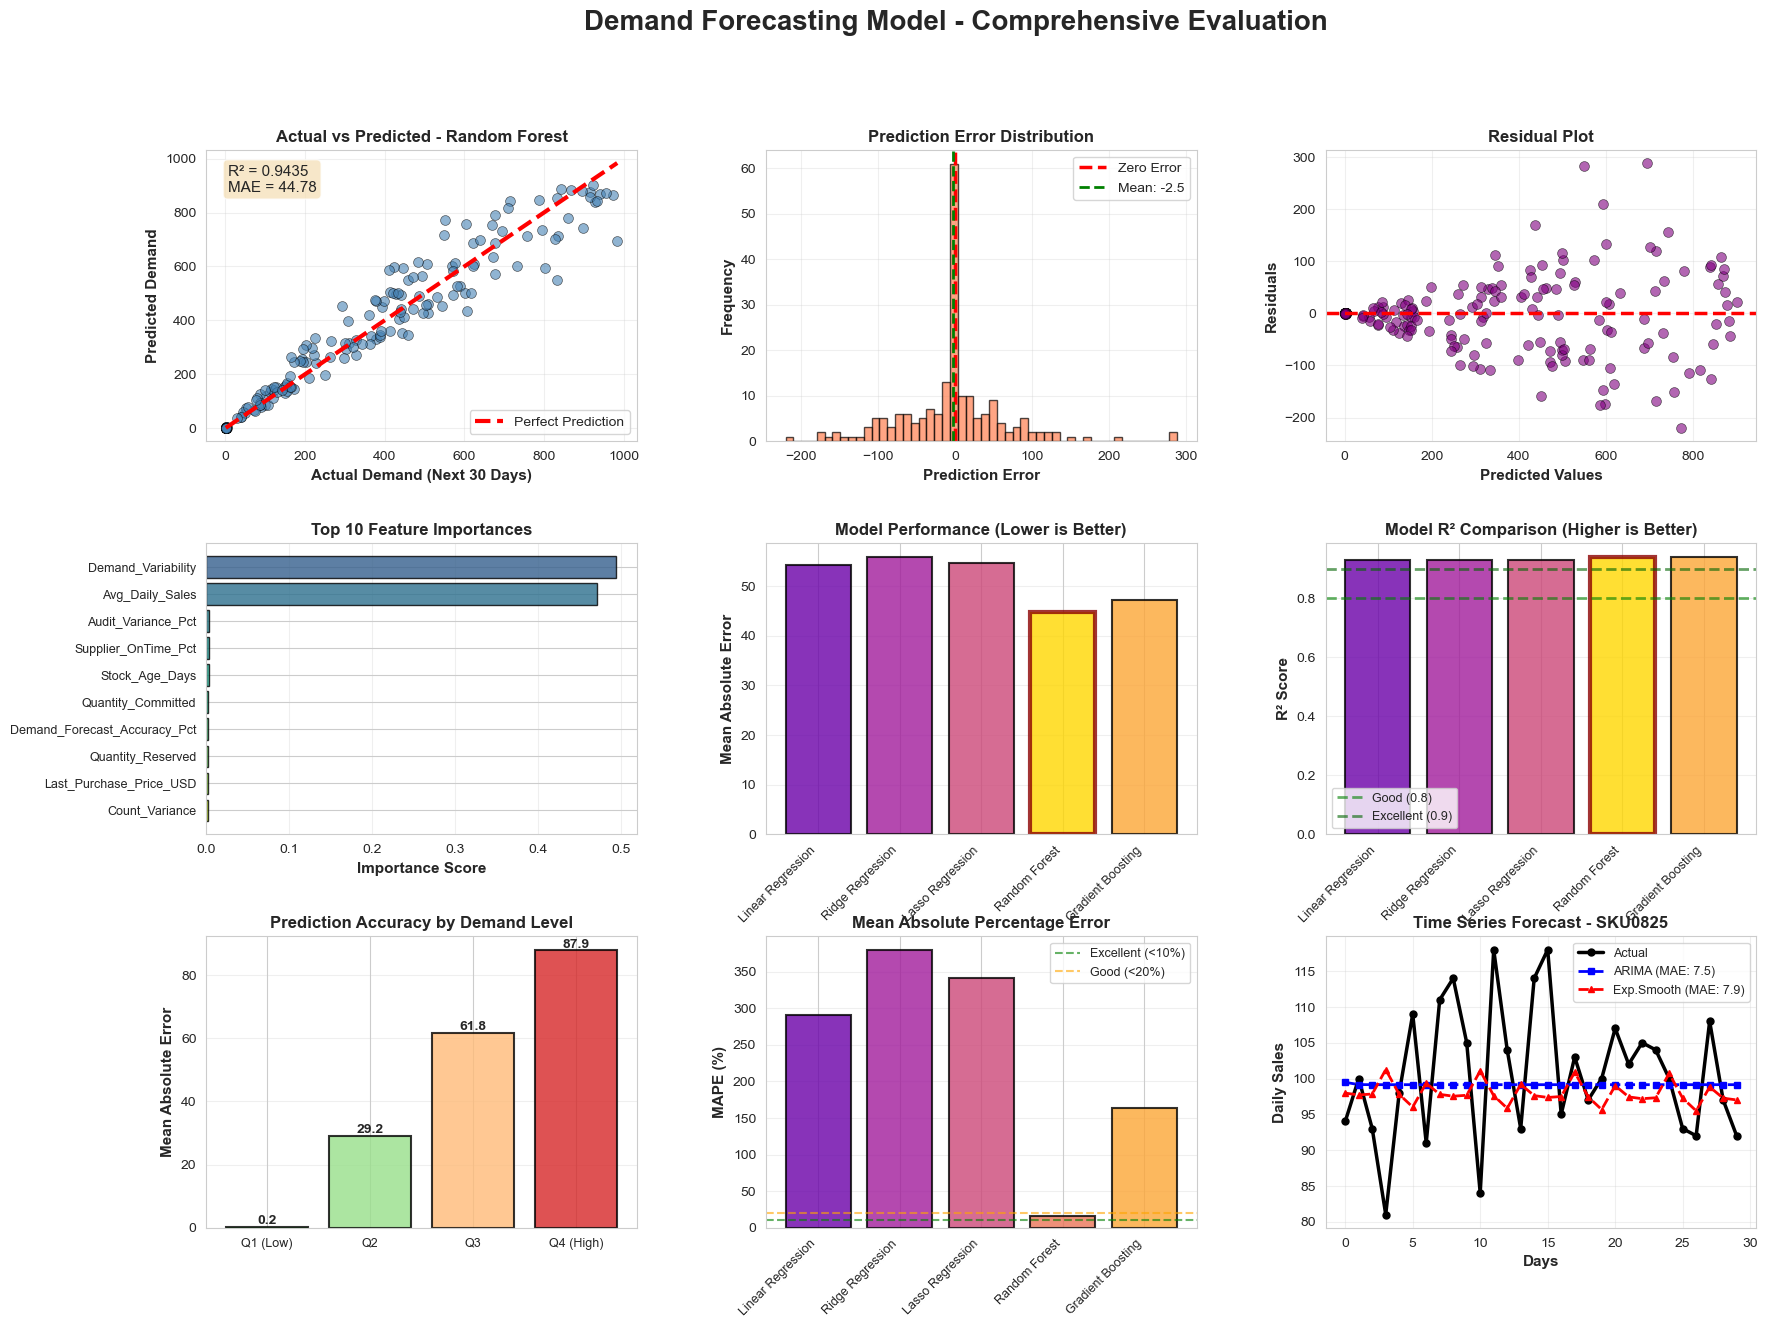

✓ Saved: 'model_evaluation_comprehensive.png'


In [44]:
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)
fig.suptitle('Demand Forecasting Model - Comprehensive Evaluation', 
             fontsize=20, fontweight='bold')

# Plot 1: Actual vs Predicted
ax1 = fig.add_subplot(gs[0, 0])
y_pred_best = results[best_model_name]['predictions']
ax1.scatter(y_test, y_pred_best, alpha=0.6, color='steelblue', s=50, edgecolors='black', linewidth=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=3, label='Perfect Prediction')
ax1.set_xlabel('Actual Demand (Next 30 Days)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Predicted Demand', fontsize=11, fontweight='bold')
ax1.set_title(f'Actual vs Predicted - {best_model_name}', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
r2_text = f'R² = {results[best_model_name]["test_r2"]:.4f}\nMAE = {results[best_model_name]["test_mae"]:.2f}'
ax1.text(0.05, 0.95, r2_text, transform=ax1.transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# Plot 2: Prediction Error Distribution
ax2 = fig.add_subplot(gs[0, 1])
errors = y_test.values - y_pred_best
ax2.hist(errors, bins=50, color='coral', edgecolor='black', alpha=0.7)
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2.5, label='Zero Error')
ax2.axvline(x=errors.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean: {errors.mean():.1f}')
ax2.set_xlabel('Prediction Error', fontsize=11, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax2.set_title('Prediction Error Distribution', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Plot 3: Residual Plot
ax3 = fig.add_subplot(gs[0, 2])
ax3.scatter(y_pred_best, errors, alpha=0.6, color='purple', s=50, edgecolors='black', linewidth=0.5)
ax3.axhline(y=0, color='red', linestyle='--', linewidth=2.5)
ax3.set_xlabel('Predicted Values', fontsize=11, fontweight='bold')
ax3.set_ylabel('Residuals', fontsize=11, fontweight='bold')
ax3.set_title('Residual Plot', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: Feature Importance
ax4 = fig.add_subplot(gs[1, 0])
if feature_importance is not None:
    top_10 = feature_importance.head(10)
    colors_feat = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_10)))
    ax4.barh(range(len(top_10)), top_10.iloc[:, 1].values, color=colors_feat, alpha=0.8, edgecolor='black')
    ax4.set_yticks(range(len(top_10)))
    ax4.set_yticklabels(top_10.iloc[:, 0].values, fontsize=9)
    ax4.set_xlabel('Importance Score', fontsize=11, fontweight='bold')
    ax4.set_title('Top 10 Feature Importances', fontsize=12, fontweight='bold')
    ax4.invert_yaxis()
    ax4.grid(True, alpha=0.3, axis='x')

# Plot 5: Model Comparison (MAE)
ax5 = fig.add_subplot(gs[1, 1])
models_list = comparison_df['Model'].values
mae_values = comparison_df['Test MAE'].values
colors_bar = plt.cm.plasma(np.linspace(0.2, 0.8, len(models_list)))
bars = ax5.bar(range(len(models_list)), mae_values, color=colors_bar, alpha=0.8, edgecolor='black', linewidth=1.5)
ax5.set_xticks(range(len(models_list)))
ax5.set_xticklabels(models_list, rotation=45, ha='right', fontsize=9)
ax5.set_ylabel('Mean Absolute Error', fontsize=11, fontweight='bold')
ax5.set_title('Model Performance (Lower is Better)', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')
best_idx = np.argmin(mae_values)
bars[best_idx].set_color('gold')
bars[best_idx].set_edgecolor('darkred')
bars[best_idx].set_linewidth(3)

# Plot 6: Model Comparison (R²)
ax6 = fig.add_subplot(gs[1, 2])
r2_values = comparison_df['Test R²'].values
bars2 = ax6.bar(range(len(models_list)), r2_values, color=colors_bar, alpha=0.8, edgecolor='black', linewidth=1.5)
ax6.set_xticks(range(len(models_list)))
ax6.set_xticklabels(models_list, rotation=45, ha='right', fontsize=9)
ax6.set_ylabel('R² Score', fontsize=11, fontweight='bold')
ax6.set_title('Model R² Comparison (Higher is Better)', fontsize=12, fontweight='bold')
ax6.axhline(y=0.8, color='green', linestyle='--', linewidth=2, alpha=0.6, label='Good (0.8)')
ax6.axhline(y=0.9, color='darkgreen', linestyle='--', linewidth=2, alpha=0.6, label='Excellent (0.9)')
ax6.grid(True, alpha=0.3, axis='y')
ax6.legend(fontsize=9)
best_r2_idx = np.argmax(r2_values)
bars2[best_r2_idx].set_color('gold')
bars2[best_r2_idx].set_edgecolor('darkred')
bars2[best_r2_idx].set_linewidth(3)

# Plot 7: Prediction Accuracy by Demand Quartile
ax7 = fig.add_subplot(gs[2, 0])
test_results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_best,
    'Error': np.abs(y_test.values - y_pred_best)
})
test_results_df['Quartile'] = pd.qcut(test_results_df['Actual'], q=4, 
                                       labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])
quartile_mae = test_results_df.groupby('Quartile')['Error'].mean()
colors_q = ['#2ca02c', '#98df8a', '#ffbb78', '#d62728']
bars3 = ax7.bar(range(len(quartile_mae)), quartile_mae.values, color=colors_q, alpha=0.8, edgecolor='black', linewidth=1.5)
ax7.set_xticks(range(len(quartile_mae)))
ax7.set_xticklabels(quartile_mae.index, fontsize=9)
ax7.set_ylabel('Mean Absolute Error', fontsize=11, fontweight='bold')
ax7.set_title('Prediction Accuracy by Demand Level', fontsize=12, fontweight='bold')
ax7.grid(True, alpha=0.3, axis='y')
for bar in bars3:
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

# Plot 8: MAPE Comparison
ax8 = fig.add_subplot(gs[2, 1])
mape_values = comparison_df['MAPE (%)'].values
bars4 = ax8.bar(range(len(models_list)), mape_values, color=colors_bar, alpha=0.8, edgecolor='black', linewidth=1.5)
ax8.set_xticks(range(len(models_list)))
ax8.set_xticklabels(models_list, rotation=45, ha='right', fontsize=9)
ax8.set_ylabel('MAPE (%)', fontsize=11, fontweight='bold')
ax8.set_title('Mean Absolute Percentage Error', fontsize=12, fontweight='bold')
ax8.axhline(y=10, color='green', linestyle='--', linewidth=1.5, alpha=0.6, label='Excellent (<10%)')
ax8.axhline(y=20, color='orange', linestyle='--', linewidth=1.5, alpha=0.6, label='Good (<20%)')
ax8.grid(True, alpha=0.3, axis='y')
ax8.legend(fontsize=9)

# Plot 9: Time Series Example
ax9 = fig.add_subplot(gs[2, 2])
if ts_results:
    first_sku = list(ts_results.keys())[0]
    ts_data = ts_results[first_sku]
    x_vals = range(len(ts_data['actual']))
    
    ax9.plot(x_vals, ts_data['actual'], 'o-', label='Actual', 
            color='black', linewidth=2.5, markersize=5)
    ax9.plot(x_vals, ts_data['arima_pred'], 's--', 
            label=f'ARIMA (MAE: {ts_data["arima_mae"]:.1f})', 
            color='blue', linewidth=2, markersize=4)
    ax9.plot(x_vals, ts_data['es_pred'], '^--', 
            label=f'Exp.Smooth (MAE: {ts_data["es_mae"]:.1f})', 
            color='red', linewidth=2, markersize=4)
    ax9.set_xlabel('Days', fontsize=11, fontweight='bold')
    ax9.set_ylabel('Daily Sales', fontsize=11, fontweight='bold')
    ax9.set_title(f'Time Series Forecast - {first_sku}', fontsize=12, fontweight='bold')
    ax9.legend(fontsize=9)
    ax9.grid(True, alpha=0.3)
else:
    ax9.text(0.5, 0.5, 'Time Series\nAnalysis\nNot Available', 
            ha='center', va='center', fontsize=14, fontweight='bold',
            transform=ax9.transAxes)

plt.savefig('model_evaluation_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: 'model_evaluation_comprehensive.png'")

In [45]:
print("\n" + "="*80)
print("[STEP 8] Business Insights & Strategic Recommendations")
print("="*80)


[STEP 8] Business Insights & Strategic Recommendations


In [46]:
print("\n8.1 Generating predictions for all SKUs...")


8.1 Generating predictions for all SKUs...


In [47]:
df_clean['Predicted_Demand_30d'] = np.nan
df_clean.loc[y_test.index, 'Predicted_Demand_30d'] = y_pred_best

# Predict for remaining SKUs
remaining_idx = df_clean[df_clean['Predicted_Demand_30d'].isna()].index
if len(remaining_idx) > 0:
    X_remaining = df_clean.loc[remaining_idx, feature_cols]
    X_remaining_clean = X_remaining.fillna(0)
    X_remaining_scaled = scaler.transform(X_remaining_clean)
    remaining_preds = best_model.predict(X_remaining_scaled)
    df_clean.loc[remaining_idx, 'Predicted_Demand_30d'] = remaining_preds

print(f"✓ Generated predictions for {len(df_clean)} SKUs")

# 8.2: Risk scoring
print("\n8.2 Calculating risk scores...")

if all(col in df_clean.columns for col in ['Predicted_Demand_30d', 'Quantity_On_Hand', 'Lead_Time_Days']):
    # Demand coverage in days
    df_clean['Demand_Coverage_Days'] = (df_clean['Quantity_On_Hand'] / 
                                        (df_clean['Predicted_Demand_30d'] / 30)).replace([np.inf, -np.inf], np.nan)
    
    # Lead time risk flag
    df_clean['Lead_Time_Risk'] = (df_clean['Lead_Time_Days'] > df_clean['Demand_Coverage_Days']).astype(int)
    
    # Comprehensive risk score (0-100)
    df_clean['Risk_Score'] = (
        (df_clean['Predicted_Demand_30d'] / (df_clean['Quantity_On_Hand'] + 1)) * 
        df_clean['Lead_Time_Days'] * 
        (1 + df_clean['Lead_Time_Risk'])
    )
    
    # Normalize to 0-100
    max_risk = df_clean['Risk_Score'].quantile(0.99)
    df_clean['Risk_Score_Normalized'] = (df_clean['Risk_Score'] / max_risk * 100).clip(0, 100)
    
    print("✓ Risk scores calculated")

# 8.3: High-risk SKUs
print("\n8.3 High-Risk SKUs (Top 20):")
print("-" * 80)

if 'Risk_Score_Normalized' in df_clean.columns:
    high_risk_cols = ['SKU_ID', 'SKU_Name', 'Category', 'Predicted_Demand_30d', 
                     'Quantity_On_Hand', 'Demand_Coverage_Days', 'Lead_Time_Days', 
                     'Risk_Score_Normalized']
    available_risk_cols = [col for col in high_risk_cols if col in df_clean.columns]
    
    high_risk = df_clean.nlargest(20, 'Risk_Score_Normalized')[available_risk_cols]
    print(high_risk.round(2).to_string(index=False))
    
    # Export
    high_risk.to_csv('high_risk_skus.csv', index=False)
    print("\n✓ Saved: 'high_risk_skus.csv'")

# 8.4: Reorder recommendations
print("\n8.4 Reorder Point Recommendations (Top 15):")
print("-" * 80)

if all(col in df_clean.columns for col in ['Predicted_Demand_30d', 'Lead_Time_Days', 'Safety_Stock', 'Reorder_Point']):
    # Optimal reorder point formula
    df_clean['Optimal_Reorder_Point'] = (
        (df_clean['Predicted_Demand_30d'] / 30) * df_clean['Lead_Time_Days'] + 
        df_clean['Safety_Stock']
    )
    
    df_clean['Reorder_Point_Gap'] = df_clean['Optimal_Reorder_Point'] - df_clean['Reorder_Point']
    
    reorder_cols = ['SKU_ID', 'SKU_Name', 'Category', 'Reorder_Point', 
                   'Optimal_Reorder_Point', 'Reorder_Point_Gap', 'Predicted_Demand_30d']
    available_reorder_cols = [col for col in reorder_cols if col in df_clean.columns]
    
    needs_adjustment = df_clean[np.abs(df_clean['Reorder_Point_Gap']) > 10].nlargest(15, 'Reorder_Point_Gap', keep='all')[available_reorder_cols]
    
    if len(needs_adjustment) > 0:
        print(needs_adjustment.round(2).to_string(index=False))
        
        # Export
        all_reorder = df_clean[available_reorder_cols].copy()
        all_reorder.to_csv('reorder_recommendations.csv', index=False)
        print("\n✓ Saved: 'reorder_recommendations.csv'")

# 8.5: Executive summary
print("\n8.5 EXECUTIVE SUMMARY:")
print("="*80)

✓ Generated predictions for 1000 SKUs

8.2 Calculating risk scores...
✓ Risk scores calculated

8.3 High-Risk SKUs (Top 20):
--------------------------------------------------------------------------------
 SKU_ID              SKU_Name      Category  Predicted_Demand_30d  Quantity_On_Hand  Demand_Coverage_Days  Lead_Time_Days  Risk_Score_Normalized
SKU0231  Household Product 48     Household                215.78                 0                  0.00               1                 100.00
SKU0268  Personal Product 380 Personal Care                644.24                55                  2.56              10                 100.00
SKU0282    Pantry Product 488        Pantry                601.47                37                  1.85               5                 100.00
SKU0369  Personal Product 413 Personal Care                467.50                48                  3.08              14                 100.00
SKU0554  Personal Product 357 Personal Care                450.36    

In [52]:
print("="*80)
print(f"✅ COMPLETE! Best Model: {best_model_name} | R²: {results[best_model_name]['test_r2']:.3f} | MAE: {results[best_model_name]['test_mae']:.2f}")


✅ COMPLETE! Best Model: Random Forest | R²: 0.944 | MAE: 44.78
